In [1]:
# Imports and Spark Session Initialization (The Definitive Windows Fix is Applied Here)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, count, lit, when, floor
from pyspark.sql.types import IntegerType
import pandas as pd 
import matplotlib.pyplot as plt 

# Set critical Spark configurations to bypass native Windows I/O issues
spark = SparkSession.builder \
    .appName("CarDatasetAnalysis") \
    .config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2") \
    .config("spark.speculation", "false") \
    .config("spark.hadoop.mapreduce.fileoutputcommitter.class", "org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter") \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .getOrCreate()

# Set log level to minimize verbosity
spark.sparkContext.setLogLevel("ERROR")

print("Spark Session Initialized.")

Spark Session Initialized.


In [2]:
# Load Data and Initial Exploration
file_path = 'car_sale_dataset.csv'

# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

print("--- PySpark DataFrame Schema ---")
df.printSchema()

print("\n--- First 5 Rows of Data ---")
df.show(5)

--- PySpark DataFrame Schema ---
root
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Engine size: double (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Year of manufacture: integer (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Price_per_km: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- Mileage_Group: string (nullable = true)


--- First 5 Rows of Data ---
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|Manufacturer|     Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|Age|Price_per_km|Category|Mileage_Group|
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|     Porsche|718 Cayman|        4.0|   Petrol|               2016|  57850|49704|  9|      0.8592| Premiu

In [3]:
# Aggregation - Average Price and Mileage by Manufacturer
print("--- Average Price and Mileage by Manufacturer (PySpark) ---")

# Group by Manufacturer and calculate the mean of Price and Mileage
manufacturer_summary_df = df.groupBy("Manufacturer") \
    .agg(\
        round(avg("Price"), 2).alias("Average_Price"),\
        round(avg("Mileage"), 0).cast(IntegerType()).alias("Average_Mileage")\
    ) \
    .sort(col("Average_Price").desc())

# Show the results
manufacturer_summary_df.show()

--- Average Price and Mileage by Manufacturer (PySpark) ---
+------------+-------------+---------------+
|Manufacturer|Average_Price|Average_Mileage|
+------------+-------------+---------------+
|     Porsche|     51476.83|          55796|
|         BMW|     49325.33|          52320|
|      Toyota|      34939.3|          39370|
|        Ford|     29760.16|          32735|
|          VW|     29159.33|          30923|
+------------+-------------+---------------+



In [4]:
# Transformation - Creating a Mileage Group (Categorical Binning)
print("--- Transformation: Creating 'Mileage_Group' ---")

# Calculate the mileage quartiles
mileage_quantiles = df.approxQuantile("Mileage", [0.25, 0.5, 0.75], 0.01)
q1, q2, q3 = mileage_quantiles[0], mileage_quantiles[1], mileage_quantiles[2]
print(f"Calculated Mileage Quartiles (Q1, Q2, Q3): {q1}, {q2}, {q3}")

# Use 'when().otherwise()' to create the categorical bins
df_transformed = df.withColumn(
    "Mileage_Group",
    when(col("Mileage") < q1, lit("Low"))
    .when((col("Mileage") >= q1) & (col("Mileage") < q2), lit("Medium"))
    .when((col("Mileage") >= q2) & (col("Mileage") < q3), lit("High"))
    .otherwise(lit("Very High"))
)

# Display the value counts for the new column and save to a variable for plotting
print("\n--- Value Counts for New 'Mileage_Group' Column ---")
mileage_counts_df = df_transformed.groupBy("Mileage_Group").count().sort(col("count").desc())
mileage_counts_df.show()

--- Transformation: Creating 'Mileage_Group' ---
Calculated Mileage Quartiles (Q1, Q2, Q3): 21913.0, 35200.0, 52241.0

--- Value Counts for New 'Mileage_Group' Column ---
+-------------+-----+
|Mileage_Group|count|
+-------------+-----+
|    Very High| 3031|
|          Low| 2940|
|         High| 2913|
|       Medium| 2889|
+-------------+-----+



In [5]:
# Filtering - Select only 'Premium' category cars
print("--- Filtering: 'Premium' Cars Dataset ---")

# Filter the DataFrame
premium_cars_df = df_transformed.where(col("Category") == "Premium")

# Show the first few rows of the filtered data
premium_cars_df.show(5)

--- Filtering: 'Premium' Cars Dataset ---
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|Manufacturer|     Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|Age|Price_per_km|Category|Mileage_Group|
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|     Porsche|718 Cayman|        4.0|   Petrol|               2016|  57850|49704|  9|      0.8592| Premium|    Very High|
|        Ford|    Mondeo|        1.6|   Diesel|               2014|  39190|24072| 11|      0.6142| Premium|         High|
|        Ford|     Focus|        1.4|   Petrol|               2018|  33603|29204|  7|      0.8691| Premium|       Medium|
|      Toyota|     Prius|        1.4|   Hybrid|               2015|  30663|30297| 10|      0.9881| Premium|       Medium|
|      Toyota|      RAV4|        2.0|   Hybrid|               2018|  28381|52671|  7|      1.8559| Premi

In [6]:
# Writing Filtered Data (Windows Workaround: toPandas)
output_filename = "premiums_cars_filtered_output.csv"

print(f"\n--- Saving filtered data using Pandas workaround to: {output_filename} ---")

try:
    # 1. Convert the Spark DataFrame to a local Pandas DataFrame for writing
    premium_cars_filtered_pandas_df = premium_cars_df.toPandas()
    
    # 2. Use Pandas to write the CSV file, bypassing Hadoop I/O
    premium_cars_filtered_pandas_df.to_csv(output_filename, index=False)
    
    # Convert the full transformed DF to Pandas for visualization in the next cell
    df_full_pandas = df_transformed.toPandas()
    
    print("Data saved successfully using the Pandas workaround.")

except Exception as e:
    print(f"An error occurred during the Pandas write operation: {e}")


--- Saving filtered data using Pandas workaround to: premiums_cars_filtered_output.csv ---
Data saved successfully using the Pandas workaround.



--- Visualization: Generating and Saving 3 Graphs ---


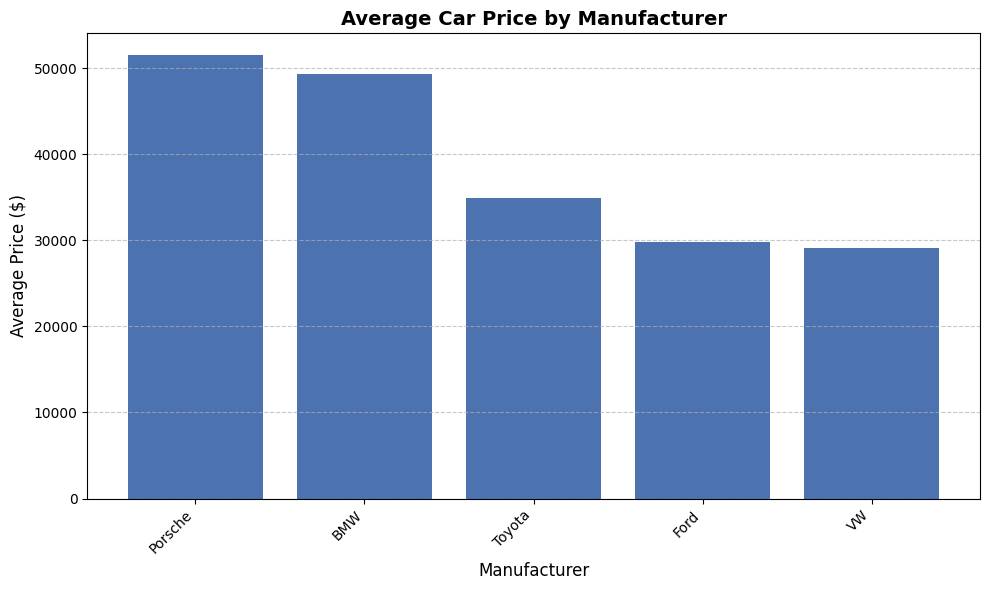

Graph saved as manufacturer_avg_price.png


In [7]:
# Visualization of Key Insights (Saves 3 PNG files)
print("\n--- Visualization: Generating and Saving 3 Graphs ---")

# Prepare data frames for plotting
manufacturer_pdf = manufacturer_summary_df.toPandas()
mileage_counts_pdf = mileage_counts_df.toPandas()

# --- 7a. Graph 1: Average Price by Manufacturer (manufacturer_avg_price.png) ---
plt.figure(figsize=(10, 6))
plt.bar(manufacturer_pdf['Manufacturer'], manufacturer_pdf['Average_Price'], color='#4C72B0')
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.title('Average Car Price by Manufacturer', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # <-- THIS COMMAND DISPLAYS THE GRAPH IN JUPYTER
plt.savefig('manufacturer_avg_price.png') 
plt.close() 
print("Graph saved as manufacturer_avg_price.png")

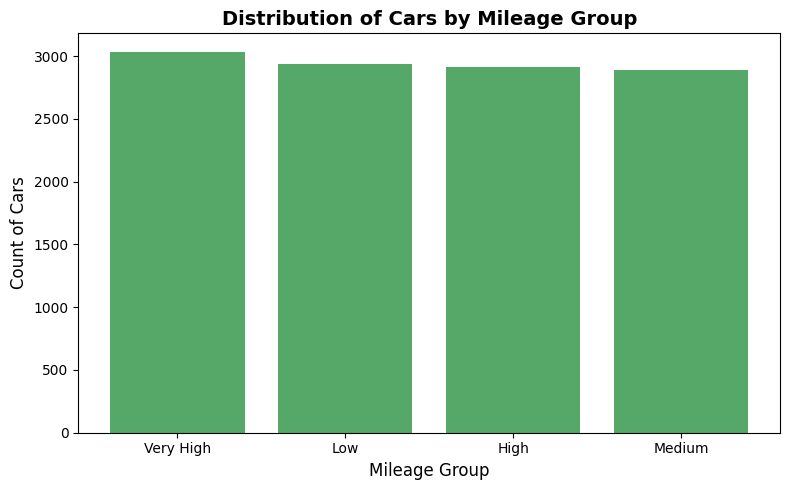

Graph saved as mileage_group_distribution.png


In [8]:
# --- 7b. Graph 2: Mileage Group Counts (mileage_group_distribution.png) ---
plt.figure(figsize=(8, 5))
plt.bar(mileage_counts_pdf['Mileage_Group'], mileage_counts_pdf['count'], color='#55A868')
plt.xlabel('Mileage Group', fontsize=12)
plt.ylabel('Count of Cars', fontsize=12)
plt.title('Distribution of Cars by Mileage Group', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() # <-- THIS COMMAND DISPLAYS THE GRAPH IN JUPYTER
plt.savefig('mileage_group_distribution.png')
plt.close() 
print("Graph saved as mileage_group_distribution.png")

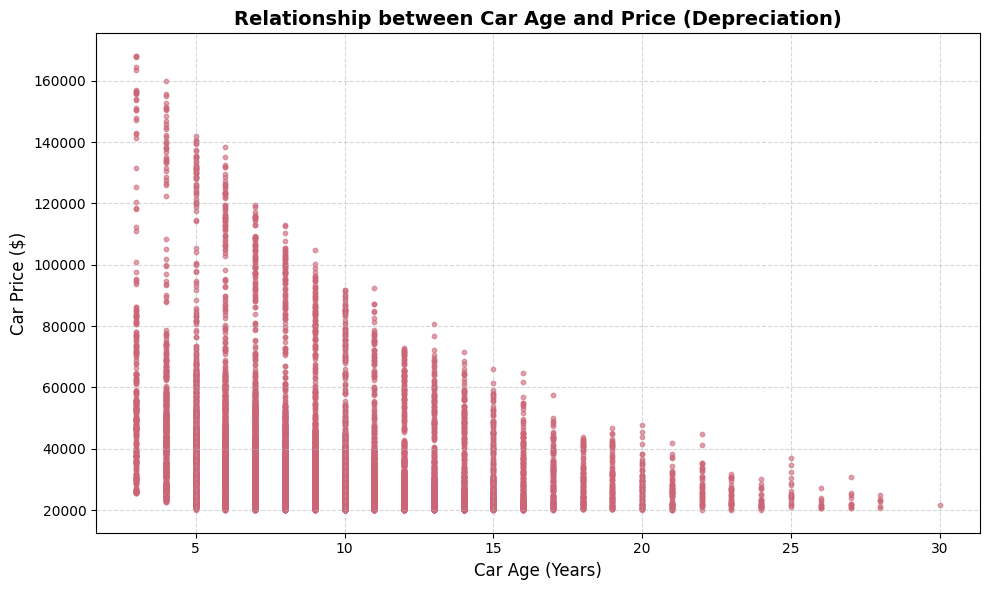

Graph saved as age_vs_price_scatter.png


In [9]:
# --- 7c. Graph 3: Scatter Plot - Age vs. Price (age_vs_price_scatter.png) ---
plt.figure(figsize=(10, 6))
plt.scatter(df_full_pandas['Age'], df_full_pandas['Price'], alpha=0.6, color='#CC6677', s=10) 
plt.xlabel('Car Age (Years)', fontsize=12)
plt.ylabel('Car Price ($)', fontsize=12)
plt.title('Relationship between Car Age and Price (Depreciation)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show() # <-- THIS COMMAND DISPLAYS THE GRAPH IN JUPYTER
plt.savefig('age_vs_price_scatter.png') 
plt.close() 
print("Graph saved as age_vs_price_scatter.png")

In [10]:
# Stop Spark Session
spark.stop()